## Gradient Boosting
Here, similar to adaboosting, we sequentially add new predictors to the ensemble, each trying to correct its predecessor.    
Except here, instead of tweaking weights of predictors, Gradient Boosting trains the new predictors on _residual errors_ made by its predecessor

_Flow of algorithm_:  
- We train first predictor on original targets
- Then we will train another predictor on _residual errors_ of first predictor. (i.e This predictor will predict those _errors_).
- Then we will again train another predictor to predict _residual errors_ of _residual errors_ of previous predictor. This will happen till either we reach perfect predictor or reach max number of predictors that we want. 
- Then, to predict we will add all the predictions made by all predictors 

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

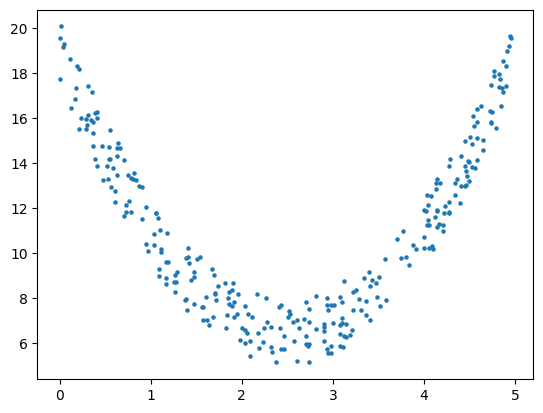

In [159]:
## Example : Gradient Boosted Regression Tree (GRBT) or Gradient Tree Boosting
X = 5*np.random.rand(300) 
y = 5 + 2*((X-2.5)**2) + 3*np.random.rand(300)

X = X.reshape(-1,1)
plt.scatter(X,y,s=5)

In [160]:
from sklearn.tree import DecisionTreeRegressor
d_reg1 = DecisionTreeRegressor(max_depth=2,random_state=42)
d_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [161]:
y2 = y - d_reg1.predict(X)
d_reg2 = DecisionTreeRegressor(max_depth=2,random_state=42)
d_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [162]:
y3 = y2 - d_reg2.predict(X)
d_reg3 = DecisionTreeRegressor(max_depth=2,random_state=42)
d_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [163]:
# For final prediction, we will add their individual predictions
def predict_y(x):
    y_pred = sum([tree.predict(x) for tree in [d_reg1,d_reg2,d_reg3]])
    return y_pred

predict_y([[0],[2],[1]])

array([16.98685135,  6.72338306,  8.92227551])

(Below is graph of same things (only the values are different)), READ IT

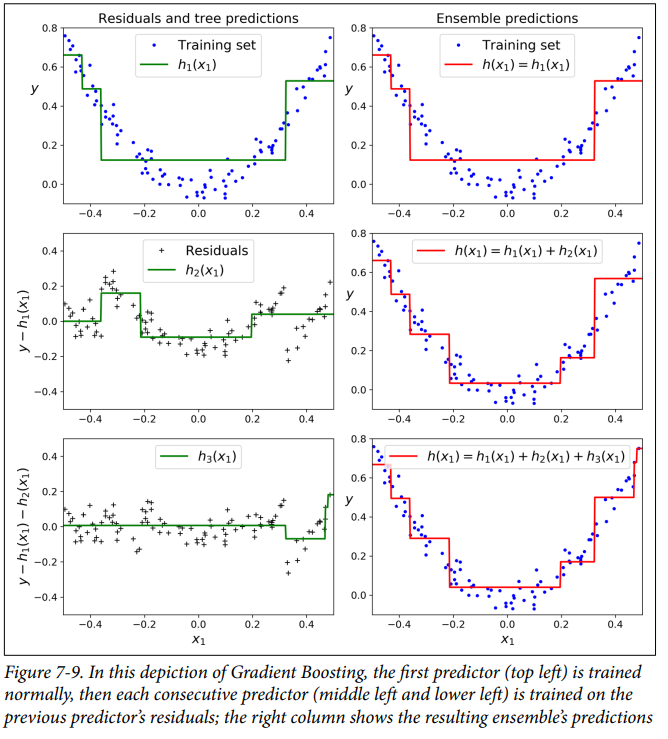

In [164]:
# The same is done with GradientBoostingRegressor in sklearn
from sklearn.ensemble import GradientBoostingRegressor

g_boost = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0)  
g_boost.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [165]:
g_boost.predict([[0],[1],[2]])

array([16.98685135,  8.92227551,  6.72338306])

### ___How to select number of estimators?___  
- One way is, we use early stopping, with the help me `staged_predict` method 
- Another way is, `warm_start=True`

Method 1
- Train a model with high number of trees

In [166]:
from sklearn.model_selection import train_test_split
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120,learning_rate=1.0)
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.3,shuffle=True,random_state=42)

gbrt.fit(x_train,y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=120)

In [167]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_val,gbrt.predict(x_val))

1.3607561840833322

- `staged_predict` method returns an iterator of predictions made at every stage in ensemble (tree1,tree2...), we use this and get optimum number of estimators

In [200]:
errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(x_val)]

best_n_estimators = int(np.argmin(errors)) + 1  #argmin returns index of least value in iterator
best_n_estimators

9

- Then we train model on that many number of iterators

In [201]:
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=best_n_estimators,learning_rate=1.0)
gbrt.fit(x_train,y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=9)

In [202]:
mean_squared_error(y_val,gbrt.predict(x_val))

1.170146124227612

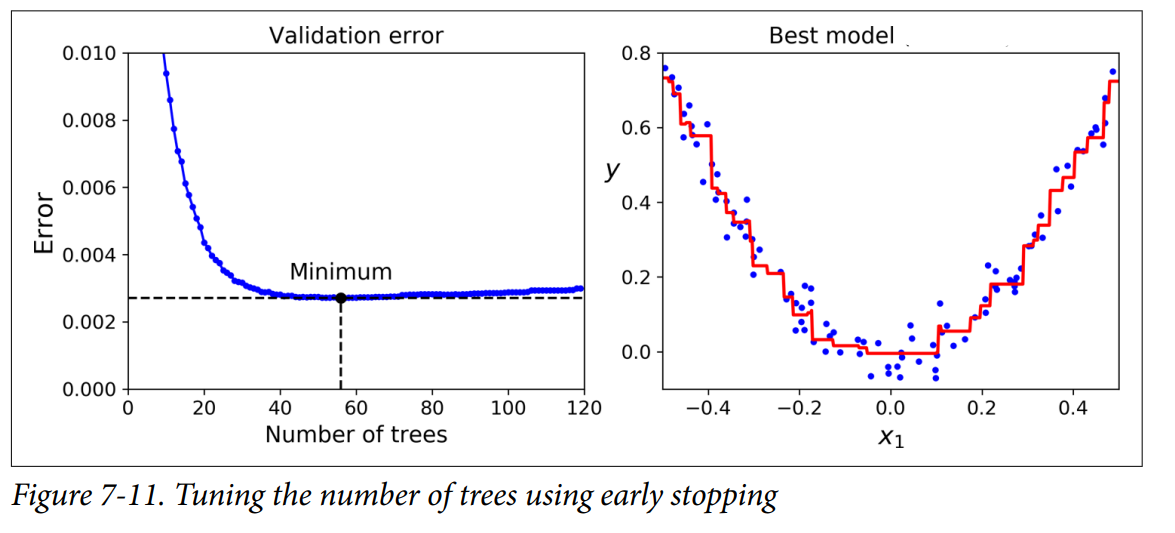

Method 2
- Use `warm_start=True`  
Generally, when you call 'fit' on a transformer, it removes previously trained data and trains new data. By doing _warm start=True_, sklearn keeps all the previously trained trees and adds new trees to previous if .fit method is called again

In [203]:
# The following code stops when validation error does not imporve for five times in a row

def best_estimator(x_train,y_train,x_val,y_val,max_trees=120,patience=5,max_depth=2,learning_rate=1.0):

    gbrt = GradientBoostingRegressor(max_depth=max_depth, learning_rate=learning_rate,
                                     warm_start=True,random_state=42)

    min_val_error = float('inf')
    error_increase = 0

    for n_estimator in range(1,max_trees):
        gbrt.n_estimators = n_estimator
        gbrt.fit(x_train,y_train)

        y_val_pred = gbrt.predict(x_val)
        val_error = mean_squared_error(y_val,y_val_pred)

        if val_error<min_val_error:
            min_val_error = val_error
            error_increase = 0 
            best_trees = n_estimator
        else :
            error_increase += 1
            if error_increase == patience:
                break
    
    best_model = GradientBoostingRegressor(learning_rate=learning_rate,max_depth=max_depth,
                                           n_estimators=best_trees,random_state=42)
    
    best_model.fit(x_train,y_train)
    return best_model

In [204]:
best_model = best_estimator(x_train,y_train,x_val,y_val)
best_model

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=9,
                          random_state=42)

In [191]:
best_model.n_estimators_

9

In [209]:
mean_squared_error(y_val,best_model.predict(x_val))

1.170146124227612

___Note___    
- _Stochastic Gradient Boosting_

Another hyperparameter of GradientBoostedRegression is _`subsample`_ This controls the ratio of training data to be used in training of each tree, ex: 0.25 mean random 25% of data will be used for training of each tree.  
This again trades _higher bias_ for _lower variance_ 

In [210]:
best_model.subsample = 0.25
best_model

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=9,
                          random_state=42, subsample=0.25)

In [212]:
mean_squared_error(y_val,best_model.predict(x_val))

1.170146124227612